# An Exploration of Lethal Outcomes in Cases of Myocardial Infarction

#### <center>Yi-Jin Chen, John Arnn, Luis Alegria</center>

### <center>Introduction</center>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Myocardial infarctions (MI), commonly referred to as heart attacks, occur after a blockage in the blood vessels supplying oxygen to heart muscles. This medical condition is considered life-threatening, and individuals not administered medical treatments promptly can have lethal outcomes. Certain risk factors and conditions predispose individuals to suffer heart attacks. These include hypertension, cigarette smoking, type II diabetes, and a sedentary lifestyle (1). In the United States, an estimated 805,000 individuals suffer a heart attack annually, and 1 in 5 may not perceive that they have suffered one (2). Given that heart attacks are prevalent and can lead to loss of life, it is essential to determine factors and medical treatments that can reduce the possibility of a lethal outcome. <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Our group chose to analyze a data set collected by Golovenkin et al. to explore MI using machine learning methods (3). This set contains information for MI patients seen at Krasnoyarsk Interdistrict Clinical Hospital in Russia from 1992-1995. It consists of 111 features, excluding the ID column, and 12 outcomes. Of the 111 features, nine were collected at various time points after hospital admission. For the outcomes, 11 have binary classes while one, lethal outcome,  has eight classes. The main objective of the analysis will be to use the features at the time of admission to classify lethal outcome after transformation into a binary class.

### <center> Imports </center>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering


plt.style.use('ggplot')

import warnings 

warnings.filterwarnings("ignore")

### <center> Data Preparation </center>

To prepare the data set for analysis the following are performed:
- drop ID column
- drop features recorded after patient admission to hospital
- drop outcomes not related to mortality
- convert mortality outcome from multi-class to binary class.

In [2]:
# Read CSV file containing the data.

mi = pd.read_csv('Myocardial infarction complications Database.csv')

In [3]:
# In its raw state, the data set contains 1700 instances with 124 columns. 

mi.shape

(1700, 124)

In [4]:
# First few entries of the set# ID, features after admission, 
# and any outcome not lethal outcome needs to be removed

# features after admission : First three are for pain relapse, second three for use
# opioids in the ICU, last three for use of NSAIDs

# Outcomes to be dropped: Atrial fibrillation, Supraventricular tachycardia, 
# Ventricular tachycardia, Ventricular fibrillation, Third-degree AV block,
# Pulmonary edema, Myocardial rupture, Dressler syndrome, Chronic heart failure,
# Relapse of the myocardial infarction, Post-infarction angina

#list of column labels to be dropped
drop_columns = ['ID',
               'R_AB_1_n', 'R_AB_2_n', 'R_AB_3_n', 'NA_R_1_n', 'NA_R_2_n',
               'NA_R_3_n', 'NOT_NA_1_n', 'NOT_NA_2_n', 'NOT_NA_3_n',
               'FIBR_PREDS', 'PREDS_TAH', 'JELUD_TAH', 'FIBR_JELUD', 'A_V_BLOK',
               'OTEK_LANC', 'RAZRIV', 'DRESSLER', 'ZSN', 'REC_IM', 'P_IM_STEN']

mi = mi.drop(columns = drop_columns)

# after the drops, there is 102 features and the outcome
mi.shape

(1700, 103)

In [5]:
# outcome has eight classes
mi['LET_IS'].value_counts()

0    1429
1     110
3      54
7      27
6      27
4      23
2      18
5      12
Name: LET_IS, dtype: int64

In [6]:
# turn outcome into binary class with 0 <- alive 1 <- deceased

mi = mi.replace({'LET_IS': [i for i in range(1, 8)]}, 1)
mi['LET_IS'].value_counts()

0    1429
1     271
Name: LET_IS, dtype: int64

In [7]:
mi.head()

,AGE,SEX,INF_ANAM,STENOK_AN,FK_STENOK,IBS_POST,IBS_NASL,GB,SIM_GIPERT,DLIT_AG,...,LID_KB,NITR_S,LID_S_n,B_BLOK_S_n,ANT_CA_S_n,GEPAR_S_n,ASP_S_n,TIKL_S_n,TRENT_S_n,LET_IS
0,77.0,1,2.0,1.0,1.0,2.0,NaN,3.0,0.0,7.0,...,NaN,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0
1,55.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0
2,52.0,1,0.0,0.0,0.0,2.0,NaN,2.0,0.0,2.0,...,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0
3,68.0,0,0.0,0.0,0.0,2.0,NaN,2.0,0.0,3.0,...,NaN,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0
4,60.0,1,0.0,0.0,0.0,2.0,NaN,3.0,0.0,7.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0


### <center> Descriptive Statistics and Missing Values </center>

In this section the aim is to explore the dataset using descriptive statistics and visualizations as well as investigate missing values in the data set.

In [8]:
# Separate the data into featurea and outcome or target

X = mi.drop(columns = ['LET_IS'])
y = mi['LET_IS']

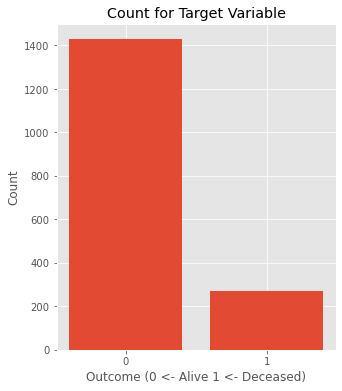

In [10]:
# bar plot to visualize counts of outcome values
# The plot shows that the data is unbalanced

fig, ax = plt.subplots(figsize = (5, 6))
ax.bar(x = [0, 1], height = y.value_counts())
ax.set_xticks([0, 1])
ax.set_xlabel('Outcome (0 <- Alive 1 <- Deceased)')
ax.set_ylabel('Count')
ax.set_title('Count for Target Variable')
plt.show()

In [11]:
# There are many features are not numeric, because they use number to classify. 
# They're actually categorical features.
# Binary data was treated as categorical data; ordinal data was treated as continuous variables (numerical) for simpler interpretation. 
# Reason from: https://www3.nd.edu/~rwilliam/stats3/OrdinalIndependent.pdf

# List to hold integer values of columns with numerical features
features = [0, *range(2,6), 7, 9, 10, *range(33,37), *range(43,47), 82, *range(84,91)]

# List to hold integer values of columns with categorical values
categories = [i for i in range(X.columns.size) if not (i in features)]

# locate all numerical features
numfeatures = X.iloc[:, features]

# locate all categorical features
catfeatures = X.iloc[:, categories]

# Print the total number in each category
print('The total number of numerical features:', len(numfeatures.columns))
print('The total number of categorical features:', len(catfeatures.columns))

The total number of numerical features: 24
The total number of categorical features: 78


In [12]:
# Describe method on the numerical features
numfeatures.describe()

,AGE,INF_ANAM,STENOK_AN,FK_STENOK,IBS_POST,GB,DLIT_AG,ZSN_A,S_AD_KBRIG,D_AD_KBRIG,...,inf_im,post_im,K_BLOOD,NA_BLOOD,ALT_BLOOD,AST_BLOOD,KFK_BLOOD,L_BLOOD,ROE,TIME_B_S
count,1692.000000,1696.000000,1594.000000,1627.000000,1649.000000,1691.000000,1452.000000,1646.000000,624.000000,624.000000,...,1620.000000,1628.000000,1329.000000,1325.000000,1416.000000,1415.000000,4.000000,1575.000000,1497.000000,1574.000000
mean,61.856974,0.554835,2.316186,1.205286,1.160703,1.393258,3.340220,0.194411,136.907051,81.394231,...,1.014815,0.259214,4.191422,136.550943,0.481455,0.263717,2.000000,8.782914,13.444890,4.684244
std,11.259936,0.836801,2.440586,1.040814,0.801400,1.088803,3.098646,0.658722,34.997835,19.745045,...,1.404934,0.698850,0.754076,6.512120,0.387261,0.201802,1.095445,3.400557,11.296316,2.871044
min,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2.300000,117.000000,0.030000,0.040000,1.200000,2.000000,1.000000,1.000000
25%,54.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,120.000000,70.000000,...,0.000000,0.000000,3.700000,133.000000,0.230000,0.150000,1.350000,6.400000,5.000000,2.000000
50%,63.000000,0.000000,1.000000,2.000000,1.000000,2.000000,3.000000,0.000000,140.000000,80.000000,...,0.000000,0.000000,4.100000,136.000000,0.380000,0.220000,1.600000,8.000000,10.000000,4.000000
75%,70.000000,1.000000,5.000000,2.000000,2.000000,2.000000,7.000000,0.000000,160.000000,90.000000,...,2.000000,0.000000,4.600000,140.000000,0.610000,0.330000,2.250000,10.450000,18.000000,7.000000
max,92.000000,3.000000,6.000000,4.000000,2.000000,3.000000,7.000000,4.000000,260.000000,190.000000,...,4.000000,4.000000,8.200000,169.000000,3.000000,2.150000,3.600000,27.900000,140.000000,9.000000


From the describe method, we see that for this data set the average age for the individuals is 61.9. This means that myocardial infarctions typically occur in older individuals.  

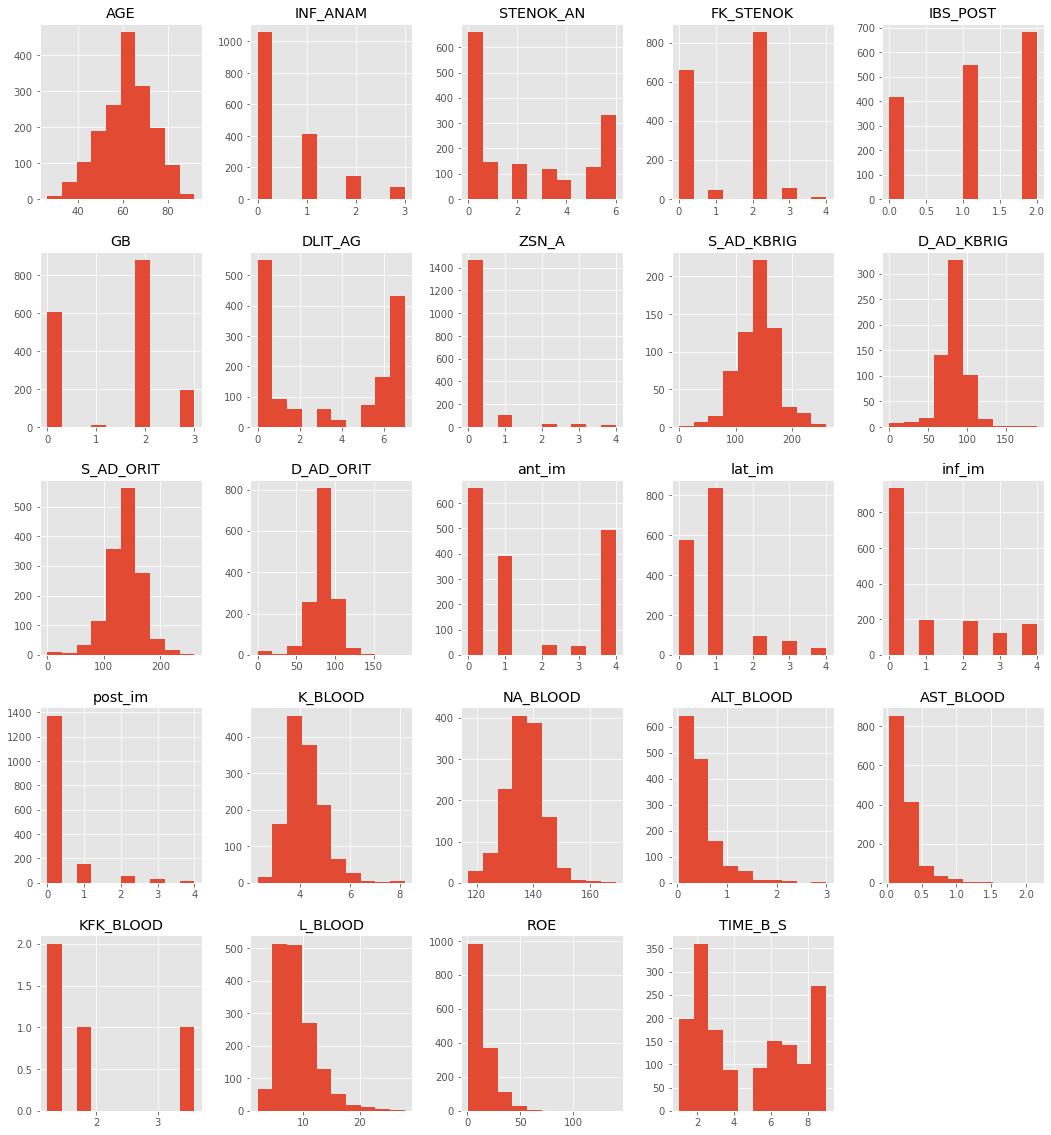

In [13]:
# Histogram for numerical features
X[numfeatures.columns].hist(figsize=(18,20))
plt.show()

*Discussion of Histograms of Numerical Features:* Some of the numerical features follow a normal distribution. These features are: age, lat_im, inf_im, post_im, K_Blood, L_Blood, ROE. Some are right-skewed. These include: Alt_blood, AST_blood. One appear to be bi-modal (TIME_B_S). 

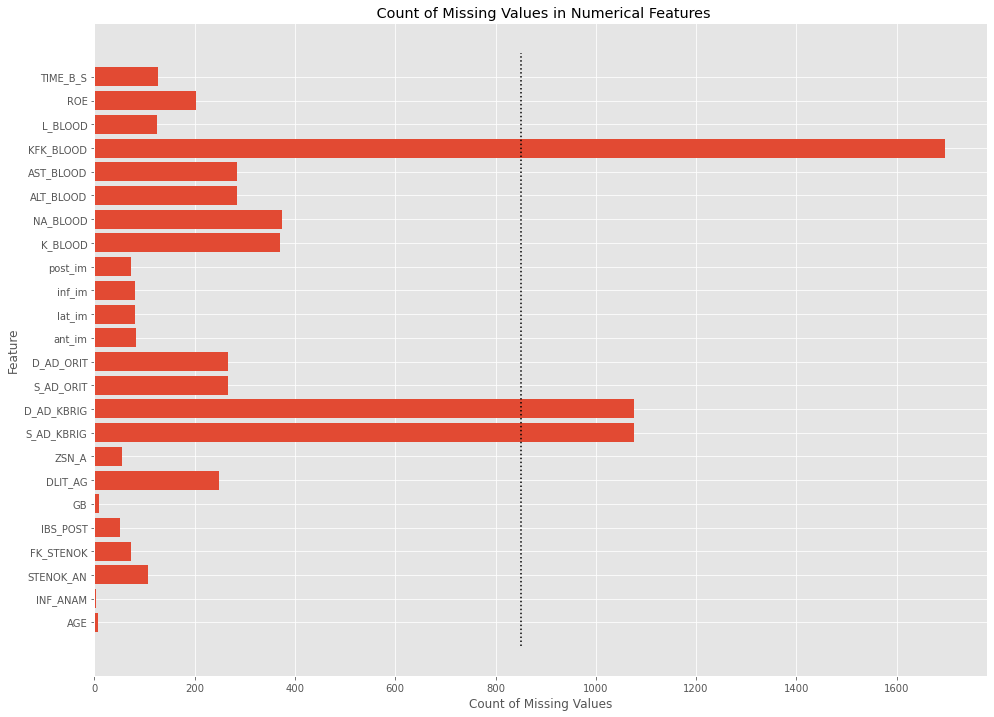

In [14]:
# Visualization of missing values in the dats set with a horizontal bar plot
# Any feature with > 50% missing values will be dropped. 

# Count of missing values.
na_count = X[numfeatures.columns].isnull().sum()
# list to hold values 0-23
marks = [i for i in range(0, len(na_count))]

fig, ax = plt.subplots(figsize = (16, 12))
ax.barh(y = marks, width = na_count.values)
ax.set_yticks(marks)
ax.set_yticklabels(na_count.index)
ax.set_xlabel('Count of Missing Values')
ax.set_ylabel('Feature')
ax.set_title(' Count of Missing Values in Numerical Features')
plt.vlines(x = 1700 / 2, ymin = -1 , ymax = 24, color = 'black',
          linestyles = 'dotted')
plt.show()

The features S_AD_KBRIG, D_AD_KBRIG, and KFK_BLOOD will be dropped since they have greater than 50% missing values.

In [15]:
# Drop the features mentioned in the cell above
newnumfeatures = numfeatures.loc[:, (numfeatures.isnull().sum(axis=0) < 1700/2)]

To explore if any of the numerical features are correlated a heat map is used. 

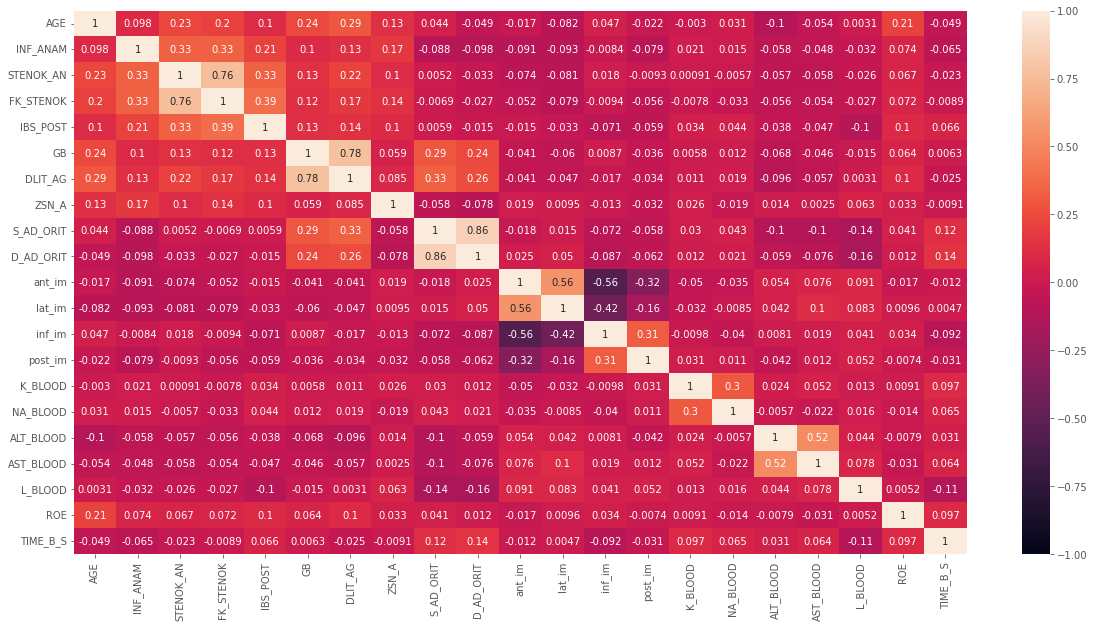

In [16]:
#Show the correlations between each two numeric variables; it seems not multi-co-linearity

plt.figure(figsize=(20,10))
cors = X[newnumfeatures.columns].corr()
sns.heatmap(cors, vmin=-1, vmax=1, annot=True)
plt.show()

*Analysis of Heatmap:* The most positively correlated features are D_AD_ORIT and S_AD_ORIT. The most negatively correlated are inf_im and ant_im. 

To look at missing values for categorical features a horizontal bar plot will also be used. 

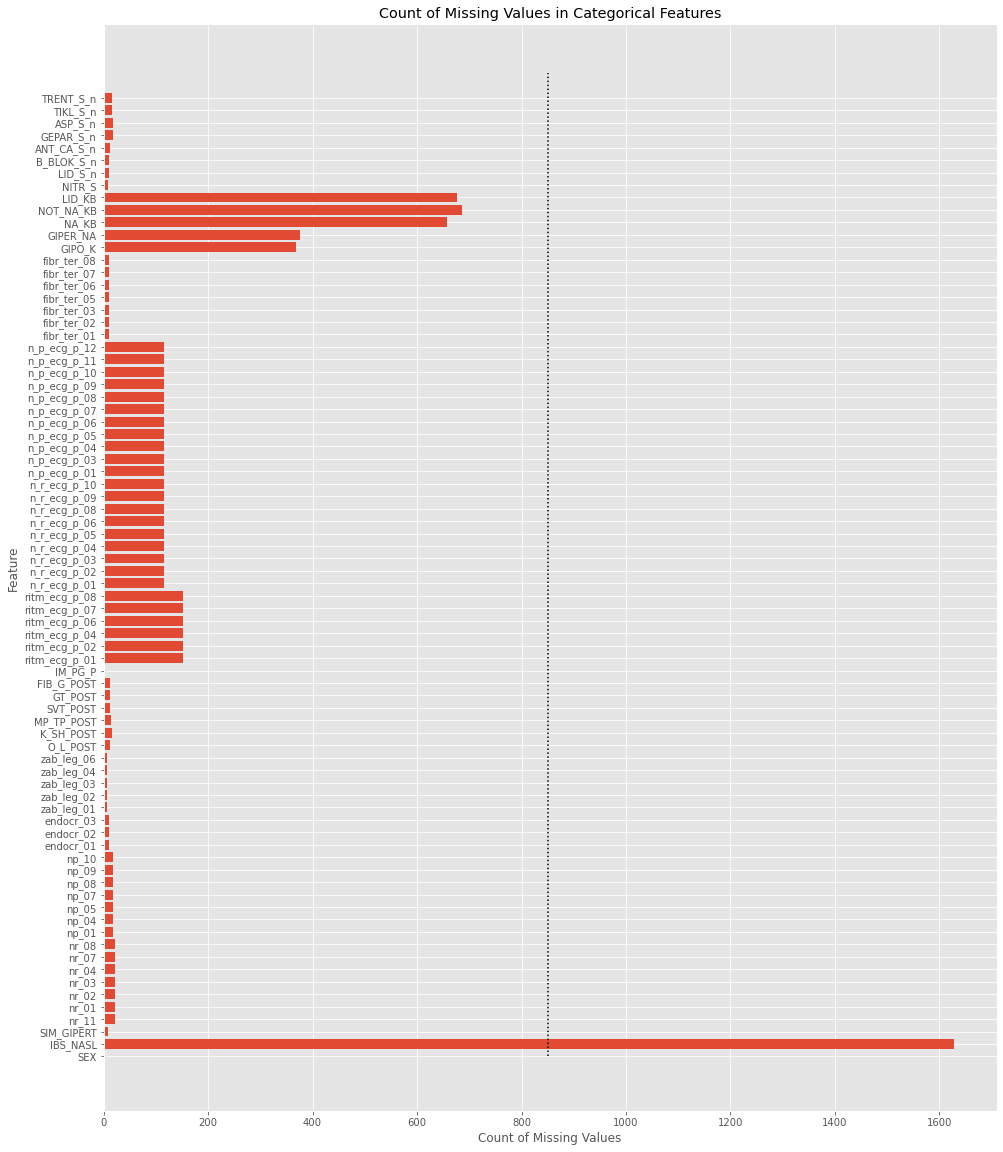

In [17]:
# Visualization of missing values in the dats set with a horizontal bar plot
# Any feature with > 50% missing values will be dropped. 

# Count of missing values.
na_count_cat = X[catfeatures.columns].isnull().sum()
# list to hold values 0-23
marks_cat = [i for i in range(0, len(na_count_cat))]

fig, ax = plt.subplots(figsize = (16, 20))
ax.barh(y = marks_cat, width = na_count_cat.values)
ax.set_yticks(marks_cat)
ax.set_yticklabels(na_count_cat.index)
ax.set_xlabel('Count of Missing Values')
ax.set_ylabel('Feature')
ax.set_title('Count of Missing Values in Categorical Features')
plt.vlines(x = 1700 / 2, ymin = 0 , ymax = 79, color = 'black',
          linestyles = 'dotted')
plt.show()

Since the feature IBS_NASL has >50% missing values, it will be dropped. 

In [18]:
newcatfeatures = catfeatures.loc[:, (catfeatures.isnull().sum(axis=0) < 1700/2)]

Based on the exploration above, we determined that the features S_AD_KBRIG, D_AD_KBRIG, KFK_BLOOD, and IBS_NASL are dropped due to them containing more than 50% missing values.

In [19]:
# Dropped the features from the analysis above
X = X.drop(columns = ['S_AD_KBRIG', 'D_AD_KBRIG', 'KFK_BLOOD','IBS_NASL'])
# Display shape before test-train split
X.shape

(1700, 98)

### <center> Test-Train Split </center>

The test train split will be stratified due to the imbalance of the outcome variable. In the following cell, the parameter stratify = y ensures that the same proportions of outcome variable is maintained in the splits. To ensure that we are all working with the same data, the splits will be converted to a pandas dataframe, exported to a csv file and place in out git repository. 

In [20]:
# From data exploration we found that the target varible is unbalanced so
# the data will be split in a stratified manner. 

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size = 0.2,
                                                   random_state = 42, stratify = y)

In [21]:
# concatanate training set
df_train = pd.concat([X_train, y_train], axis = 1)

# concanate test set
df_test = pd.concat([X_test, y_test], axis = 1)

In [22]:
# write data to csv
df_train.to_csv('train')

In [23]:
# write data to csv
df_test.to_csv('test')

### <center> Exploratory Data Analysis </center>

In this section the training split will be explored. The first technique that will be applied is feature selection using mutual information. The feature selection from this technique will be used in downstream analysis (hyperparameter optimization and model selection) if time permits. This technique will be followed by feature extration using Principal Component Analysis and application of clustering algorithms. The clustering algorithms that will be used are Kmeans, DBSCAN, and Spectral. The results for Kmeans and Spectral clustering will be compared to explore if there are similarities or differences. 

#### <center> Creation of Instances </center>

In [24]:
# Creation of imputer instances for categorical and numerical features
impute_num = SimpleImputer(missing_values = np.nan, strategy = 'mean')
impute_cat = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')


# Creation of feature selection instance with mutual information
mi_selector = SelectKBest(mutual_info_classif, k = 'all')

# Creation of the scaling instance
scaler = StandardScaler()

# Creation of PCA instance
pca = PCA()

#### <center> Read CSV files with Training Data </center>

In [25]:
# read the csv file with the training split
train_data = pd.read_csv('train', index_col = 0)

In [26]:
# separate training data into X and y matrices
X_train = train_data.drop(columns = ['LET_IS'])
y_train = train_data['LET_IS']

#### <center> Data Imputation</center>

In [27]:
# Imputation of data. Fit method calculates mean or mode of feature
# and transform method scales the feature

# numerical features
ncols = newnumfeatures.columns
X_train[ncols] = impute_num.fit_transform(X_train[ncols])

# categorical features
ccols = newcatfeatures.columns
X_train[ccols] = impute_cat.fit_transform(X_train[ccols])

In [28]:
# check if any Nan values present 
X_train.isnull().values.any()

False

#### <center> Feature Selection </center>

In [29]:
# Set random seed and calculata mututal information values for the feature
np.random.seed(42)
# Fit method for SelectKbest
mut_inf = mi_selector.fit(X_train, y_train)

In [30]:
# If the mutual information for a feature is above 0.01 it will be selected for use in
# other analyses

# list to hold features names that are above a threshold
mi_feats = []
# loop over the scores_, and feature_names_in_ attributes
for x, y in zip(mut_inf.scores_, mut_inf.feature_names_in_):
    # condition to select features
    if x > 0.01:
        # append to list
        mi_feats.append(y)

In [31]:
# 30 features were above the threshold. 
len(mi_feats)

30

In [32]:
# At this point the number of features will be reduced from 98 to 30.

# This will determine which are categorical and which are numerical so that 
# Scaling can be done for PCA and clustering.

# convert list of important features and previous features to sets to determine intersections
mi_feats_s = set(mi_feats)
newnumfeatures_s = set(newnumfeatures.columns)
newcatfeatures_s = set(newcatfeatures.columns)

# find intersections and convert back to list
reduced_num = list(newnumfeatures_s.intersection(mi_feats))
reduced_cat = list(newcatfeatures_s.intersection(mi_feats))

In [33]:
# Select features from feature selection portion and see first few entries
X_train_sub = X_train.loc[:, mi_feats]
X_train_sub.head()

,AGE,STENOK_AN,FK_STENOK,IBS_POST,GB,ZSN_A,np_09,np_10,endocr_03,S_AD_ORIT,...,n_r_ecg_p_05,n_p_ecg_p_01,n_p_ecg_p_10,n_p_ecg_p_12,NA_BLOOD,L_BLOOD,TIME_B_S,NITR_S,ANT_CA_S_n,ASP_S_n
1414,60.0,5.0,2.0,1.000000,2.0,0.0,0.0,0.0,0.0,190.0,...,0.0,0.0,0.0,0.0,130.0,10.8,7.0,0.0,1.0,1.0
227,57.0,1.0,2.0,2.000000,2.0,0.0,0.0,0.0,0.0,120.0,...,0.0,0.0,0.0,0.0,130.0,5.1,3.0,0.0,0.0,1.0
280,52.0,0.0,0.0,2.000000,2.0,0.0,0.0,0.0,0.0,134.5,...,0.0,0.0,0.0,0.0,144.0,6.9,9.0,0.0,1.0,1.0
1538,73.0,6.0,3.0,1.149582,2.0,4.0,0.0,1.0,0.0,130.0,...,0.0,0.0,0.0,1.0,130.0,10.2,3.0,1.0,1.0,1.0
1418,78.0,2.0,2.0,2.000000,2.0,0.0,0.0,0.0,0.0,134.5,...,0.0,0.0,0.0,0.0,153.0,4.9,2.0,0.0,0.0,0.0


#### <center> Principal Component Analysis </center>

In this portion, PCA will applied to the data and some visualizations created. Plots will also be made to investigate how much data variablity each PCA captures

In [34]:
# Scaling of the numerical features
X_train_sub[reduced_num] = scaler.fit_transform(X_train_sub[reduced_num])

In [35]:
# fit and fit_transform method for pca instance applied to the data with reduced features

# used for scree and variance plots
X_train_pca_fit = pca.fit(X_train_sub)

# used for scatteplots
X_train_pca = pca.fit_transform(X_train_sub)

In [36]:
# Create a dataframe that will hold the first three PCAs and subsequent labels from
# clustering. 

pca_df = pd.DataFrame(data = X_train_pca[:, 0:3], 
                      columns = ['PC1', 'PC2', 'PC3'])

In [37]:
# reset index for Y_train split
y_train_idx = y_train.reset_index(drop = True)

In [38]:
# Add outcome to pca_df
pca_df['outcome'] = y_train_idx

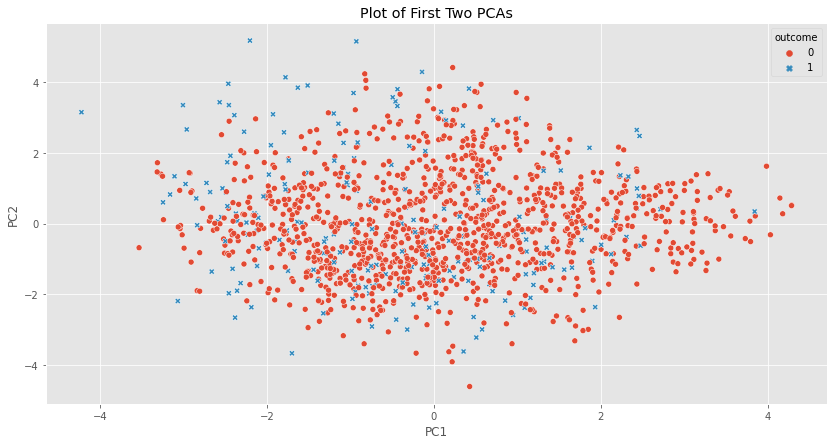

In [39]:
# Create scatter plot for first two PCAs

fig, ax = plt.subplots(figsize = (14, 7))

sns.scatterplot(x = 'PC1', y = 'PC2',  data = pca_df, hue = 'outcome',
                style = 'outcome' )
plt.title('Plot of First Two PCAs')
plt.show()

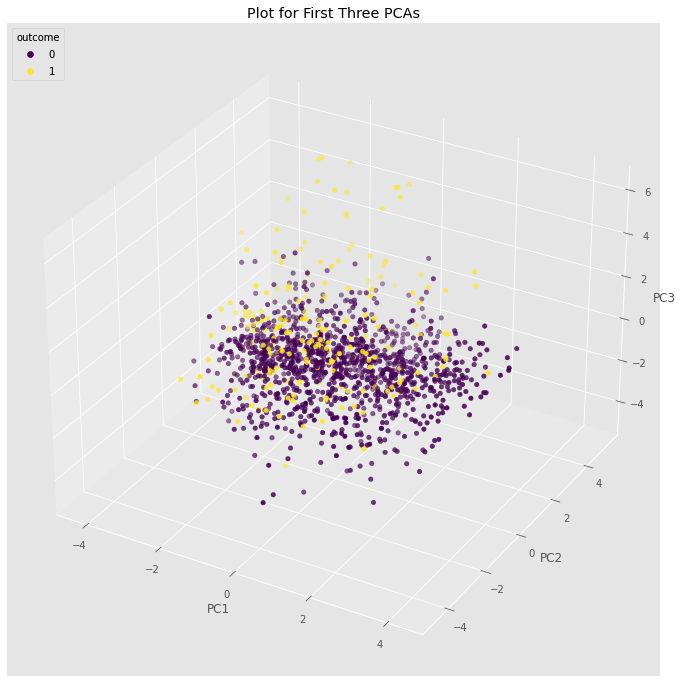

In [65]:
# 3-D Scatter plot for first 3 PCAs

fig = plt.figure(figsize = (16, 12))
ax = fig.add_subplot(projection = '3d')
xp = pca_df['PC1']
yp = pca_df['PC2']
zp = pca_df['PC3']
scatters = ax.scatter(xp, yp, zp, c = pca_df['outcome'])
legend2 = ax.legend(*scatters.legend_elements(),
                    loc = 'upper left', title = 'outcome')
ax.add_artist(legend2)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title('Plot for First Three PCAs')
plt.show()

In [41]:
# values to produce a scree plot 
y_scree = X_train_pca_fit.explained_variance_ratio_
x_scree = list(range(0, 30))

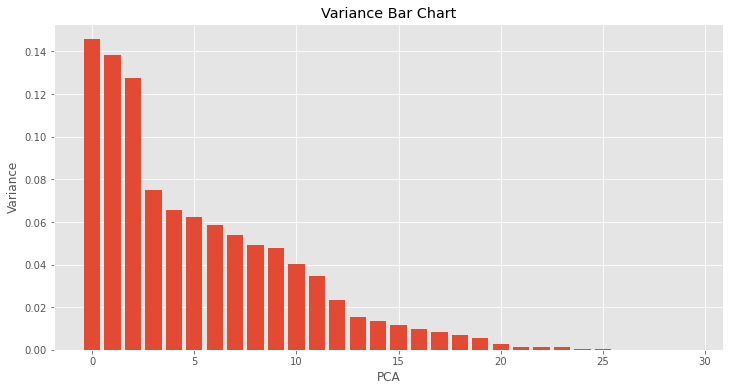

In [42]:
# barplot for variance captured by each PCA
fig, ax = plt.subplots(figsize = (12, 6))
ax.bar(x_scree, y_scree)
ax.set_xlabel('PCA')
ax.set_ylabel('Variance')
plt.title('Variance Bar Chart')
plt.show()

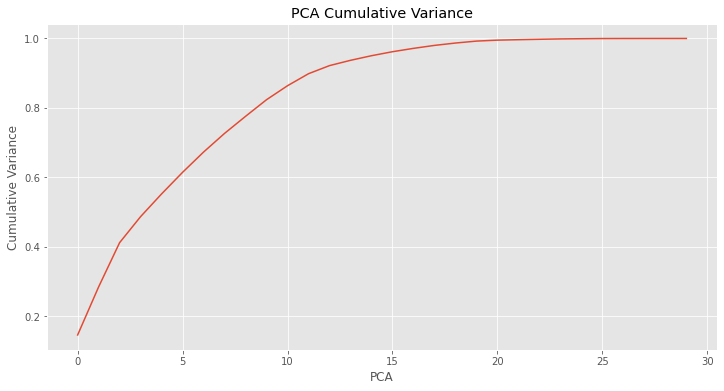

In [43]:
# Cumulative sum of variance for PCAs
fig, ax = plt.subplots(figsize = (12, 6))
ax.plot(x_scree, y_scree.cumsum())
ax.set_xlabel('PCA')
ax.set_ylabel('Cumulative Variance')
plt.title('PCA Cumulative Variance')
plt.show()

**PCA Discussion:** From the analysis of PCA, it was found that the first 13 PCs explain about 0.98 of the variance of the data. These components will be used for the clustering portion.

#### <center> PCA and K-means Clustering </center>

For this section, inertia values will be used to find the optimal number of k. 

In [44]:
# Select the first 13 components to be used for clustering
cluster = X_train_pca[:, 0:13] 

In [45]:
# calculate the inertia values for k = 1 - 150
# list to hold values
inertia_values = list()
# loop over the values
for k in range(1, 151):
    # fit method to data
    kmeans = KMeans(n_clusters = k, random_state = 42).fit(cluster)
    # append inertia values to list
    inertia_values.append(kmeans.inertia_)

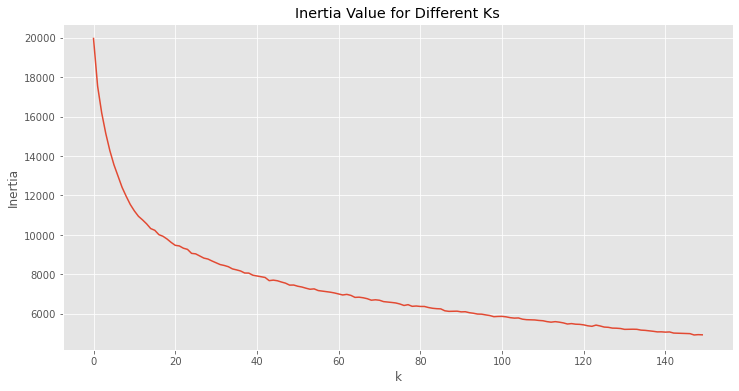

In [46]:
# plot the inertia values found. 
fig, ax = plt.subplots(figsize = (12, 6))
ax.plot(range(0, len(inertia_values)), inertia_values)
ax.set_xlabel('k')
ax.set_ylabel('Inertia')
plt.title('Inertia Value for Different Ks')
plt.show()

**Discussion of Inertia Plot:** From the plot above, the elbow occurs at a value below 20. For the next plot, k is plotted for the number 1-30. 

In [47]:
# Second inertia values
inertia_values_2 = list()

for k in range(1, 31):
    kmeans = KMeans(n_clusters = k, random_state = 42). fit(cluster)
    inertia_values_2.append(kmeans.inertia_)

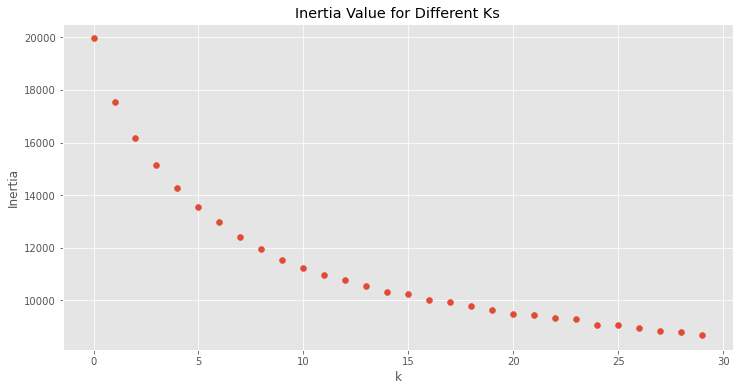

In [48]:
# Second plot of inertia values
fig, ax = plt.subplots(figsize = (12, 6))
ax.scatter(range(0, len(inertia_values_2)), inertia_values_2)
ax.set_xlabel('k')
ax.set_ylabel('Inertia')
plt.title('Inertia Value for Different Ks')
plt.show()

**Discussion of Second Inertia Plot:** The optimal k appears to be for the value 9. This k value will be used for PCA and K-means clustering visualization.

In [49]:
# Build model with k=9
k_means = KMeans(n_clusters = 9, random_state = 42)
# fit to clustering data
kmeans_opt = k_means.fit(cluster)

In [50]:
# add labels to pca dataframe
pca_df['cluster'] = kmeans_opt.labels_

Text(0.5, 1.0, 'Plot for PCA and K-means clustering')

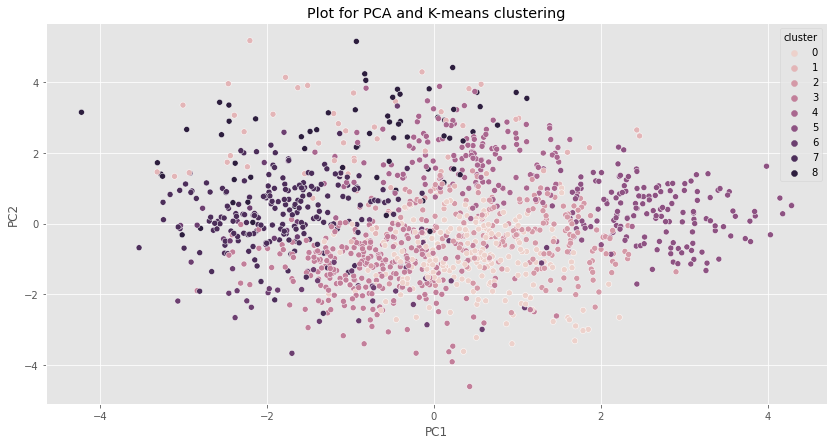

In [51]:
# Plot for PCA and K-means labels

fig, ax = plt.subplots(figsize = (14, 7))
sns.scatterplot(x = 'PC1', y = 'PC2',  data = pca_df, hue = 'cluster',
                legend = 'full', ax = ax)
plt.title('Plot for PCA and K-means clustering')

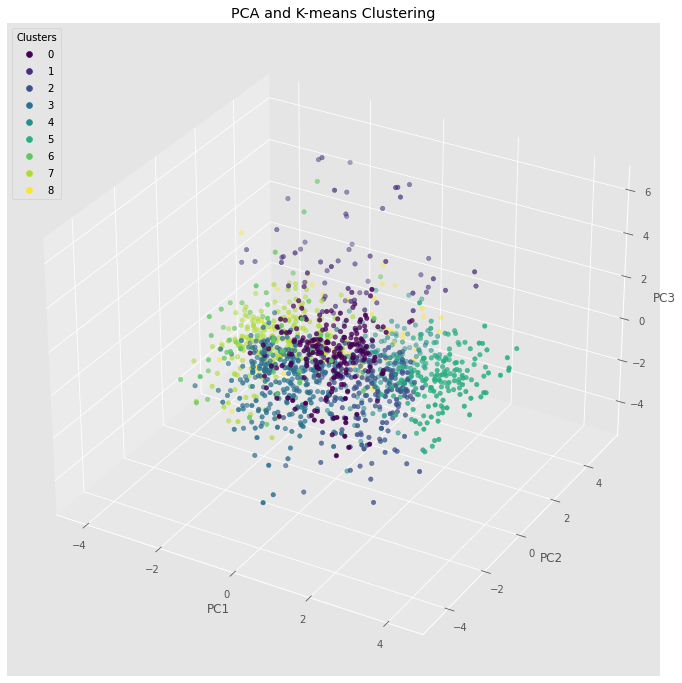

In [52]:
# plot for first 3 PC and k-means

fig = plt.figure(figsize = (16, 12))
ax = fig.add_subplot(projection = '3d')
xp = pca_df['PC1']
yp = pca_df['PC2']
zp = pca_df['PC3']
scatter = ax.scatter(xp, yp, zp, c = pca_df['cluster'])
legend1 = ax.legend(*scatter.legend_elements(),
                    loc = 'upper left', title = "Clusters")
ax.add_artist(legend1)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title('PCA and K-means Clustering')
plt.show()

#### <center> DBSCAN Clustering and First Two PCAs </center>

For this combination of algorithms, not much optimization was pursued as initial result did not yield any good values. The model was built with with the parameters in the following cell, fitted to the data, and labels plotted along with the first two PCAs. 

In [53]:
# Created intance
db_cluster = DBSCAN(eps = 4.25, min_samples = 30)
# fit model to data
db_cluster.fit(cluster)

DBSCAN(eps=4.25, min_samples=30)

In [54]:
# add labels to pca dataframe
pca_df['cluster_db'] = db_cluster.labels_

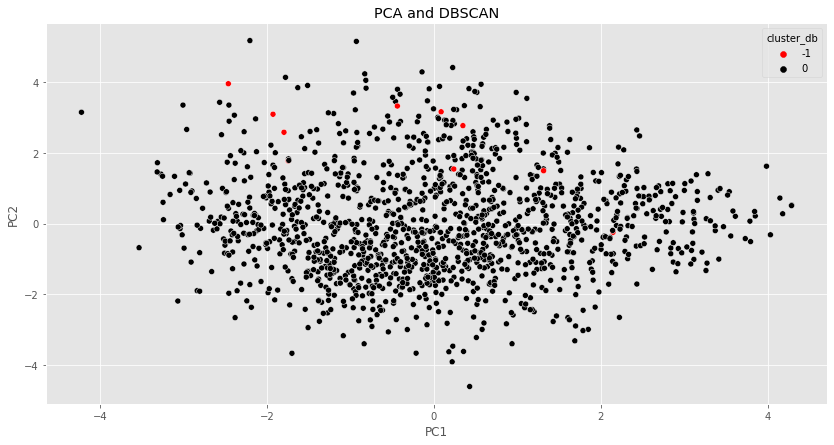

In [55]:
# Plot first two PC and labels from DBSCAN clustering
fig, ax = plt.subplots(figsize = (14, 7))
colors = {-1: 'red', 0: 'black'}
sns.scatterplot(x = 'PC1', y = 'PC2',  data = pca_df, hue = 'cluster_db',
                palette = colors, legend = 'full', ax = ax)
plt.title('PCA and DBSCAN')
plt.show()

**Discussion of DBSCAN Clustering:** DBSCAN did not yield any good clustering results. Of note however, is the points classified as noise. A further exploration can be going back to the data set before the split and determining whether these points are outliers and can be removed. 

#### <center> PCA and Spectral Clustering </center>

Optimization was not performed due to time constraints. The value for k was taken from the result found for k-means so as two compare the results for these two algorithms. 

In [56]:
# Build instance and fit method on the clustering data.
cluster_spec = SpectralClustering(n_clusters = 9, assign_labels = 'discretize',
                                random_state = 0).fit(cluster)

In [57]:
# add spectral clustering labels to pca dataframe. 
pca_df['cluster_spec'] = cluster_spec.labels_

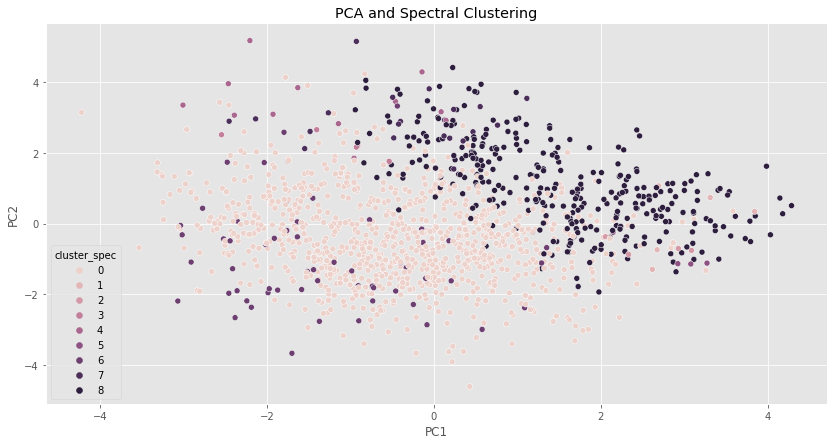

In [58]:
fig, ax = plt.subplots(figsize = (14, 7))
sns.scatterplot(x = 'PC1', y = 'PC2',  data = pca_df, hue = 'cluster_spec',
                legend = 'full', ax = ax)
plt.title('PCA and Spectral Clustering')
plt.show()

#### <center> Comparison of K-means and Spectral Clustering </center>

In [59]:
# value counts for labels given by each algorithm. 
kmeans_counts = pca_df['cluster'].value_counts() 
spec_counts = pca_df['cluster_spec'].value_counts()

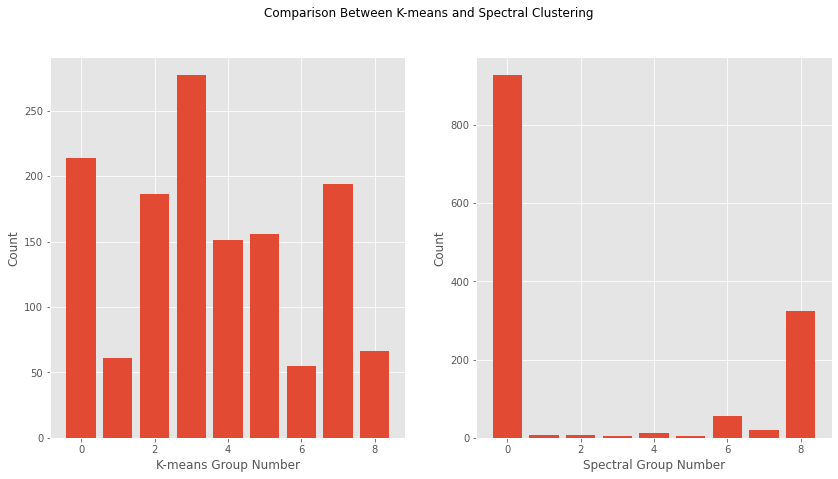

In [61]:
# bar plots for group counts in both algorithms

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 7))
fig.suptitle('Comparison Between K-means and Spectral Clustering')
ax1.bar(kmeans_counts.index, kmeans_counts.values)
ax1.set_xlabel('K-means Group Number')
ax1.set_ylabel('Count')
ax2. bar(spec_counts.index, spec_counts.values)
ax2.set_xlabel('Spectral Group Number')
ax2.set_ylabel('Count')
plt.show()

**Discussion of Comparison:** The clustering groups are more balanced in terms of counts for k-means. With spectral clustering, one group has the majority of data points. 

### <center>Sources</center>
<br>
1. Heart Attack. Johns Hopkins Medicine. Accessed October 8, 2021. https://www.hopkinsmedicine.org/health/conditions-and-diseases/heart-attack
<br>
<br>
2. Heart Disease Facts. Centers for Disease Control and Prevention. Accessed October 9, 2021. https://www.cdc.gov/heartdisease/facts.htm
<br>
<br>
3. Golovenkin, S.E.; Gorban, Alexander; Mirkes, Evgeny; Shulman, V.A.; Rossiev, D.A.; Shesternya, P.A.; et al. (2020): Myocardial infarction complications Database. University of Leicester. Dataset. https://doi.org/10.25392/leicester.data.12045261.v3 